In [1]:
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from IPython.utils import io
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [2]:
features = pd.read_csv('Dataset/gastrointestinal_colonoscopy_lesions_dataset.csv')
features = features.T
class_label = pd.Series(features.index)
features.index = range(features.shape[0])
classes = np.zeros((features.shape[0], 3))
for i in range(classes.shape[0]):
    if 'adenoma' in class_label[i]:
        classes[i,0] = 1.0
        class_label[i] = 0
    elif 'serrated' in class_label[i]:
        classes[i,2] = 1.0
        class_label[i] = 2
    else:
        classes[i,1] = 1.0
        class_label[i] = 1
classes = {'adenoma': classes[:,0], 'hyperplasic': classes[:,1], 'serrated': classes[:,2]}
classes = pd.DataFrame(classes)
class_label = class_label.astype('int')

In [3]:
for col in features.columns:
    if features[col].abs().max()==0:
        continue
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
features

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.250000,-0.25,0.048325,-0.005553,-0.056058,-0.084224,-0.037834,-0.031987,-0.101462,-0.050684,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
1,0.250000,0.25,-0.001203,0.367137,-0.084265,-0.100569,0.018451,0.046227,-0.101911,-0.038210,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
2,0.250000,0.25,-0.233810,0.046065,0.024136,0.032700,-0.031101,-0.036372,-0.169688,-0.154002,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
3,0.250000,-0.25,-0.182565,0.057049,-0.031463,-0.025114,-0.050518,-0.035422,-0.067798,-0.052955,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
4,0.250000,0.25,-0.107936,-0.094438,0.092679,0.038768,0.186656,0.125008,0.095410,0.078630,...,-0.054256,-0.053808,-0.052869,-0.052718,-0.051934,-0.051097,-0.050394,-0.050345,-0.049870,-0.049726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.25,0.040649,-0.066683,-0.185786,-0.250955,-0.163660,-0.173238,-0.232896,-0.223542,...,-0.054095,-0.053643,-0.052701,-0.052581,-0.051796,-0.050957,-0.050288,-0.050236,-0.049758,-0.049611
148,-0.083333,0.25,-0.153445,0.092191,-0.010435,-0.057762,-0.097339,-0.111005,-0.120050,0.000883,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
149,-0.083333,-0.25,0.144594,0.231284,-0.043448,-0.041229,-0.173962,-0.202734,-0.153664,-0.000519,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
150,-0.083333,-0.25,-0.169496,-0.098815,-0.207792,-0.250433,-0.221289,-0.226000,0.073333,0.138157,...,-0.053643,-0.053247,-0.052332,-0.052204,-0.051450,-0.050608,-0.049938,-0.049907,-0.049461,-0.049344


In [4]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(3, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()
model.save_weights('model_weights/initial_weights_colonoscopy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 4907      
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 4,965
Trainable params: 4,965
Non-trainable params: 0
_________________________________________________________________


In [5]:
acc = 0
j = 0
for train_index, test_index in LeaveOneOut().split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_colonoscopy')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=500)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 34ms/step - loss: 0.1347 - accuracy: 1.0000


1/1 [==============================] - 0s 26ms/step - loss: 0.6061 - accuracy: 0.0000e+00


In [6]:
print('Accuracy: ', acc/j)

Accuracy:  0.8552631578947368


In [7]:
model.fit(features, classes, epochs=500)

Epoch 1/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.9934
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0630 - accuracy: 0.9934
Epoch 3/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0624 - accuracy: 0.9934
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0620 - accuracy: 0.9934
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9934
Epoch 6/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 1.0000
Epoch 7/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 1.0000
Epoch 8/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 1.0000
Epoch 9/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0599 - accuracy: 1.0000
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0595 - accuracy: 1.0000
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 0.0422 - accuracy: 1.0000
Epoch 85/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0420 - accuracy: 1.0000
Epoch 86/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0418 - accuracy: 1.0000
Epoch 87/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 1.0000
Epoch 88/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0415 - accuracy: 1.0000
Epoch 89/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 1.0000
Epoch 90/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0411 - accuracy: 1.0000
Epoch 91/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 1.0000
Epoch 92/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 1.0000
Epoch 93/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 1.0000
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 1.0000
Epoch 168/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0304 - accuracy: 1.0000
Epoch 169/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 1.0000
Epoch 170/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 1.0000
Epoch 171/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 1.0000
Epoch 172/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 1.0000
Epoch 173/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 1.0000
Epoch 174/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 1.0000
Epoch 175/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 1.0000
Epoch 176/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0296 - accuracy: 1.0000
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 250/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 251/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 252/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0228 - accuracy: 1.0000
Epoch 253/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 1.0000
Epoch 254/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 1.0000
Epoch 255/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 1.0000
Epoch 256/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 1.0000
Epoch 257/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 1.0000
Epoch 258/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 1.0000
Epoch 259/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 332/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 333/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 334/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 335/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 336/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 1.0000
Epoch 337/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 1.0000
Epoch 338/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 339/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 340/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 341/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 414/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 415/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 416/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 1.0000
Epoch 417/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 418/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 419/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 420/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 421/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 422/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0136 - accuracy: 1.0000
Epoch 423/500
5/5 [=====

5/5 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 496/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 497/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 498/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 499/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 500/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 1.0000


In [8]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(-np.sum(np.abs(grad_sum), 0))

100%|██████████| 700/700 [10:14<00:00,  1.14it/s]


In [9]:
print('The features arranged in order of saliency are: \n')
features[saliency_order]

The features arranged in order of saliency are: 



,0,547,549,146,459,455,425,577,464,521,...,367,412,321,332,304,350,322,369,344,290
0,0.250000,0.019453,0.013944,0.014037,-0.031571,-0.008144,0.164106,0.001114,0.156682,0.019545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250000,0.019453,0.013944,0.009191,-0.031571,-0.008144,0.110005,0.001114,-0.071990,0.019545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250000,0.012418,0.016346,0.008758,-0.031571,0.229704,0.057649,0.003952,-0.131291,0.000482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.250000,0.012418,0.016346,0.066090,-0.031571,-0.008144,0.151890,0.003952,-0.140440,0.000482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.250000,0.018683,0.017094,-0.104275,-0.031571,-0.008144,0.033216,0.001333,-0.029781,-0.004381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.006751,-0.003144,-0.029268,-0.031571,-0.008144,0.216462,-0.009436,0.063551,0.089982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,-0.083333,0.009858,0.007949,-0.007182,0.586617,-0.008144,0.027981,0.006135,-0.040653,0.019351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,-0.083333,0.009858,0.007949,0.030283,-0.031571,-0.008144,0.061139,0.006135,-0.026035,0.019351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,-0.083333,-0.044736,-0.039516,-0.007820,-0.031571,-0.008144,0.068120,0.015595,-0.140440,0.004470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[]

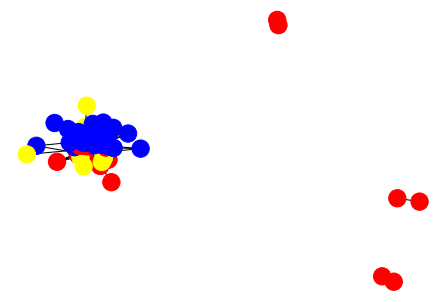

In [10]:
num_features = 100
salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
p = 1.3
A = (A < p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
for node in G:
    if (class_label[node]==0):
        color_map = np.append(color_map, 'red')
    elif (class_label[node]==1):
        color_map = np.append(color_map, 'blue')
    else:
        color_map = np.append(color_map, 'yellow')
nx.draw(G, node_color=color_map)
plt.plot()

In [30]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(salient_features)
print('***KMEANS for 3 clusters***')
print('Inertia: ', kmeans.inertia_)
print('Cluster Centers: ', kmeans.cluster_centers_)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

***KMEANS for 3 clusters***
Inertia:  140.25014389269094
Cluster Centers:  [[ 2.50000000e-01 -4.17247079e-02 -5.08163620e-02  4.96402636e-02
  -3.15710220e-02 -8.14373591e-03 -1.76207863e-01  1.68679174e-02
   4.22168828e-02 -3.67486066e-01 -3.41069899e-02 -6.05277331e-02
   1.16572462e-01 -5.69568139e-02 -2.51582451e-02  1.82973101e-02
  -1.67287235e-02 -4.10590707e-02 -1.52631173e-02  4.83040050e-02
  -1.05410161e-02  3.67188155e-02 -3.12133615e-02  6.55087003e-02
  -6.18111971e-02  6.41048237e-02  4.13488281e-02  3.72786095e-02
  -5.30342918e-01  2.95516872e-02 -5.55757186e-02 -3.13968925e-01
  -1.64779397e-01 -8.37197107e-03 -1.20857895e-02 -3.70004300e-02
   8.40017634e-02 -1.32202311e-02 -4.84451161e-02  3.29673029e-02
  -2.35280386e-02 -4.75795089e-02 -1.12970796e-02 -5.10107183e-02
  -3.49120291e-01  4.84852932e-02 -3.77193851e-02  4.56971663e-02
   9.77761850e-03  1.06316326e-01 -1.10579796e-01 -5.97481887e-01
  -3.60501833e-02 -2.90245034e-02  3.11988576e-02 -6.95331781e-02
 

In [25]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 1)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 2)
    else:
        compared_classes = np.append(compared_classes, 0)
print('KMeans accuracy for 3 classes: ', np.count_nonzero(compared_classes==predicted_label)/len(predicted_label))

KMeans accuracy for 3 classes:  0.7631578947368421


In [32]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
print('***KMEANS for 2 clusters***')
print('Inertia: ', kmeans.inertia_)
print('Cluster Centers: ', kmeans.cluster_centers_)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

***KMEANS for 2 clusters***
Inertia:  149.7334008819243
Cluster Centers:  [[-3.14102564e-01 -1.51056937e-02 -1.25916351e-02  1.50361595e-02
  -2.33199592e-02 -8.14373591e-03 -1.12944337e-01  3.40622432e-04
   5.16398634e-02 -3.33858662e-02 -1.46236838e-02 -1.23453534e-02
   7.45276430e-03 -1.03053545e-02 -8.23922926e-03  1.56478525e-03
  -5.34950813e-03 -1.38962825e-02 -2.02468932e-02  8.73981658e-02
  -2.86909574e-02  2.51286279e-03 -6.25152703e-03  7.63467073e-02
  -1.85242477e-02  8.49688196e-02  5.31201071e-03  3.48257046e-03
  -3.15345601e-02  2.26007586e-03 -4.04737104e-02 -2.91312278e-02
  -1.04549200e-01  6.78394282e-02 -1.23663866e-01  2.87539461e-03
   3.72317003e-02 -1.62234605e-02 -1.23313267e-02  6.51697714e-02
  -5.62118687e-03 -1.39937673e-02 -2.48507593e-02 -9.15522753e-03
  -3.31286673e-02  2.76893728e-02  3.75037244e-02 -2.56415847e-02
  -6.36865798e-04 -4.94543308e-02 -2.18593900e-02 -3.62956648e-02
   3.76141181e-02  3.76978415e-02  5.84116955e-02 -1.27709791e-02
  

In [33]:
print(predicted_label)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [36]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 1)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 0)
    else:
        compared_classes = np.append(compared_classes, 0)
print('KMeans accuracy for 3 classes: ', np.count_nonzero(compared_classes==predicted_label)/len(predicted_label))

KMeans accuracy for 3 classes:  0.7894736842105263


[]

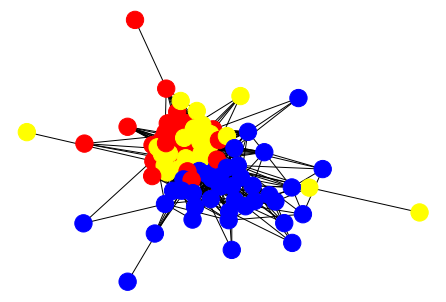

In [37]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in giant_component:
    if (class_label[node]==0):
        color_map_GC = np.append(color_map_GC, 'red')
    elif (class_label[node]==1):
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'yellow')
nx.draw(giant_component, node_color=color_map_GC)
plt.plot()

[]

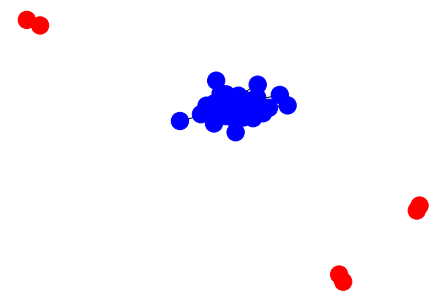

In [38]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [15]:
print(f"Density: {nx.density(giant_component)}")
print(f"Diameter: {nx.diameter(giant_component)}")
print(f"Radius: {nx.radius(giant_component)}")
print(f"Number Of Isolates: {nx.number_of_isolates(giant_component)}")
print(f"Average clustering value: {nx.average_clustering(giant_component)}")
print(f"Transitivity value: {nx.transitivity(giant_component)}")
print(f"Whether graph is connected: {nx.is_connected(giant_component)}")
print(f"Number of Connected Components: {nx.number_connected_components(giant_component)}")

Density: 0.4090500449505544
Diameter: 5
Radius: 3
Number Of Isolates: 0
Average clustering value: 0.732590199023299
Transitivity value: 0.7682840351644081
Whether graph is connected: True
Number of Connected Components: 1
